## Library Import and Configuration

In [ ]:
!pip install --quiet duckdb jupysql duckdb-engine pandas numpy seaborn matplotlib scipy scikit-learn

In [ ]:
# import duckdb
# import pandas as pd
# %reload_ext sql
# %config SqlMagic.autopandas = True
# %config SqlMagic.feedback = False
# %config SqlMagic.displaycon = False
# %sql duckdb:///:memory:

In [ ]:
# exposures = pd.read_csv(_generate_drive_link(url=TABLE_MAPPING["exposures"]))
# features = pd.read_csv(_generate_drive_link(url=TABLE_MAPPING["features"]))
# orders = pd.read_csv(_generate_drive_link(url=TABLE_MAPPING["orders"]))
# emails = pd.read_csv(_generate_drive_link(url=TABLE_MAPPING["emails"]))

# ETL

In [ ]:
# %%sql
# df <<

# WITH ranked_exposures AS (
#     SELECT user_id,
#            variant_name,
#            CAST(exposed_at AS TIMESTAMP) AS exposed_at,
#            days_since_signup,
#            ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY exposed_at ASC) AS rank
#     FROM exposures
# ),

# first_exposure_per_user AS (
#     SELECT user_id,
#            variant_name,
#            exposed_at,
#            days_since_signup
#     FROM ranked_exposures
#     WHERE rank = 1
# ),

# nearest_features_per_user AS (
#     SELECT f.*,
#            ROW_NUMBER() OVER (
#                PARTITION BY f.user_id
#                ORDER BY CAST(f.created_at AS TIMESTAMP) DESC
#            ) AS rank
#     FROM features f
#     JOIN first_exposure_per_user fe
#       ON f.user_id = fe.user_id
#     WHERE CAST(f.created_at AS TIMESTAMP) <= fe.exposed_at
# ),

# combined_orders_per_user AS (
#     SELECT o.user_id,
#            SUM(CASE WHEN CAST(o.occurred_at as TIMESTAMP) BETWEEN fe.exposed_at - INTERVAL '14 day' AND fe.exposed_at
#                     THEN 1 ELSE 0 END) AS num_past_orders_14d,
#            COUNT(CASE WHEN CAST(o.occurred_at as TIMESTAMP) BETWEEN fe.exposed_at AND fe.exposed_at + INTERVAL '7 day'
#                       THEN o.user_id ELSE NULL END) > 0 AS order_conversion,
#            SUM(CASE WHEN CAST(o.occurred_at as TIMESTAMP) BETWEEN fe.exposed_at AND fe.exposed_at + INTERVAL '7 day'
#                     THEN o.revenue ELSE 0 END) AS revenue
#     FROM orders o
#     JOIN first_exposure_per_user fe
#       ON o.user_id = fe.user_id
#     GROUP BY o.user_id
# ),

# email_clicks_per_user AS (
#     SELECT e.user_id,
#            SUM(CASE WHEN CAST(e.occurred_at AS TIMESTAMP) BETWEEN fe.exposed_at AND fe.exposed_at + INTERVAL '7 day'
#                     THEN 1 ELSE 0 END) AS num_past_clicked_emails_14d
#     FROM emails e
#     JOIN first_exposure_per_user fe
#       ON e.user_id = fe.user_id
#     GROUP BY e.user_id
# ),

# exposure_final_dataset AS (
#     SELECT fe.*,
#            nf.loyalty_points,
#            nf.sign_up_incentive,
#            comb.num_past_orders_14d,
#            comb.order_conversion,
#            comb.revenue,
#            cl.num_past_clicked_emails_14d
#     FROM first_exposure_per_user fe
#     LEFT JOIN nearest_features_per_user nf
#       ON fe.user_id = nf.user_id
#       AND nf.rank = 1
#     LEFT JOIN combined_orders_per_user comb
#       ON fe.user_id = comb.user_id
#     LEFT JOIN email_clicks_per_user cl
#       ON fe.user_id = cl.user_id
# )


# select * from exposure_final_dataset


# 1:1 Coupon Personalization

In [ ]:
# !pip install pandas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## High Level Descriptive Statistics

In [ ]:
df.head()

,user_id,variant_name,exposed_at,days_since_signup,loyalty_points,sign_up_incentive,num_past_orders_14d,order_conversion,revenue,num_past_clicked_emails_14d
0,1400,zero,2023-08-05 00:30:58.743,10.0,73.0,None,1.0,False,0.00,0.0
1,19951,10-percent,2023-07-29 03:20:31.806,0.0,NaN,Free Shipping,0.0,True,88.99,1.0
2,24002,20-percent,2023-08-05 19:29:21.902,5.0,69.0,None,1.0,False,0.00,0.0
3,33065,10-percent,2023-08-08 21:16:32.460,50.0,NaN,Free Shipping,0.0,False,0.00,0.0
4,37872,10-percent,2023-07-28 02:00:59.548,1.0,NaN,None,0.0,True,93.99,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30738 entries, 0 to 30737
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   user_id                      30738 non-null  int64         
 1   variant_name                 30738 non-null  object        
 2   exposed_at                   30738 non-null  datetime64[us]
 3   days_since_signup            30738 non-null  float64       
 4   loyalty_points               8296 non-null   float64       
 5   sign_up_incentive            22259 non-null  object        
 6   num_past_orders_14d          4800 non-null   float64       
 7   order_conversion             4800 non-null   object        
 8   revenue                      4800 non-null   float64       
 9   num_past_clicked_emails_14d  14727 non-null  float64       
dtypes: datetime64[us](1), float64(5), int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
df.describe()

,user_id,exposed_at,days_since_signup,loyalty_points,num_past_orders_14d,revenue,num_past_clicked_emails_14d
count,30738.000000,30738,30738.000000,8296.000000,4800.000000,4800.000000,14727.000000
mean,323373.204405,2023-08-06 01:18:51.428167,112.804411,200.318105,0.252083,51.390944,0.664901
min,56.000000,2023-07-24 16:00:34.213000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,160687.750000,2023-07-31 22:34:45.110750,1.000000,96.000000,0.000000,0.000000,0.000000
50%,321933.000000,2023-08-05 16:13:57.919500,20.000000,132.000000,0.000000,0.000000,0.000000
75%,485958.000000,2023-08-11 00:08:02.680250,149.000000,202.000000,0.000000,93.990000,1.000000
max,648216.000000,2023-08-16 19:58:42.799000,1711.000000,12179.000000,3.000000,943.000000,38.000000
std,187339.968054,NaN,185.105191,330.724097,0.445154,90.263539,1.808188


## Domain Based Data Cleaning

In [ ]:
df.drop(columns=['user_id'],inplace=True) #Remove user_id

print(df['sign_up_incentive'].value_counts())
print(df['order_conversion'].value_counts())

sign_up_incentive
Free Shipping    22259
Name: count, dtype: int64
order_conversion
False    3217
True     1583
Name: count, dtype: int64


In [ ]:
''' Fill 0 for customers whose information is not present for loyalty_points
    Fill 'No Free Shipping' for customers whose information is not present for sign_up_incentive
    Fill 0 for customers whose information is not present for num_past_orders_14d
    Fill 'False' for customers whose information is not present for order_conversion
    Fill 0 for customers whose information is not present for revenue
    Fill 0 for customers whose information is not present for num_past_clicked_emails_14d
'''
df.fillna({
    'loyalty_points': 0,
    'sign_up_incentive': 'No Free Shipping',
    'num_past_orders_14d': 0,
    'order_conversion':False,
    'revenue':0,
    'num_past_clicked_emails_14d':0
}, inplace=True)


In [ ]:
df.isnull().sum()

,0
variant_name,0
exposed_at,0
days_since_signup,0
loyalty_points,0
sign_up_incentive,0
num_past_orders_14d,0
order_conversion,0
revenue,0
num_past_clicked_emails_14d,0


## A/B Testing Results (Status Quo KPIs and Insights)

In [ ]:
df['variant_name'].value_counts()

,count
variant_name,
zero,10331
10-percent,10287
20-percent,10120


In [ ]:
# Calculate the KPIs from A/B Test
grouped = df.groupby('variant_name').agg(
    conversion_rate=('order_conversion', 'mean'),
    arpu=('revenue', 'mean'),
    aov=('revenue', lambda x: x[df['order_conversion']].mean()), # AOV only for users who made a purchase
    total_revenue=('revenue','sum')
).reset_index()


# Display KPIs
grouped

,variant_name,conversion_rate,arpu,aov,total_revenue
0,10-percent,0.049188,7.771765,158.000296,79948.15
1,20-percent,0.061166,9.554075,156.199095,96687.24
2,zero,0.044333,6.779706,152.928253,70041.14


In [ ]:
run_statistical_tests(df)


Statistical Tests on KPIs from A/B Testing

At 5% significane, Chi-Square Test p-value (Conversion Rate): 1.5598611212422645e-07
At 5% significance, ANOVA p-value (ARPU) is 3.899737135227769e-06
At 5% significance, ANOVA p-value (AOV): 0.6875145947047886


In [ ]:
baseline = grouped.drop(columns=['aov']).query("variant_name=='10-percent'")
baseline

,variant_name,conversion_rate,arpu,total_revenue
0,10-percent,0.049188,7.771765,79948.15


We'll only try to optimize coupons to drive CVR ad ARPU due to it's significance in coupon strategy (Under the assumption that the randomization was proper
across these variants, and orders within 7 days are attributed to couponing only).

## EDA

In [ ]:
df['order_conversion'].value_counts() # Class Imbalance: A more balanced set can be prepared if needed.

,count
order_conversion,
False,29155
True,1583


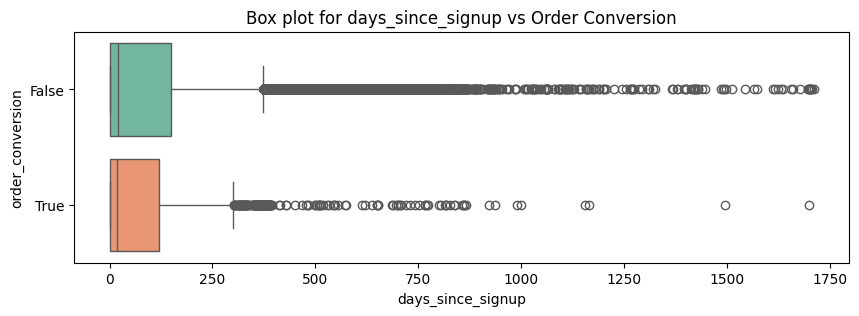

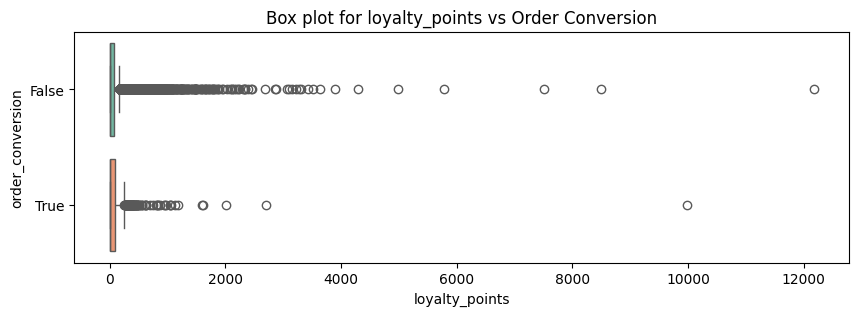

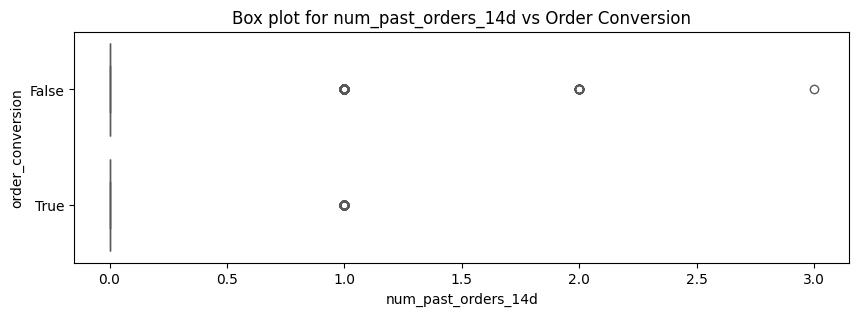

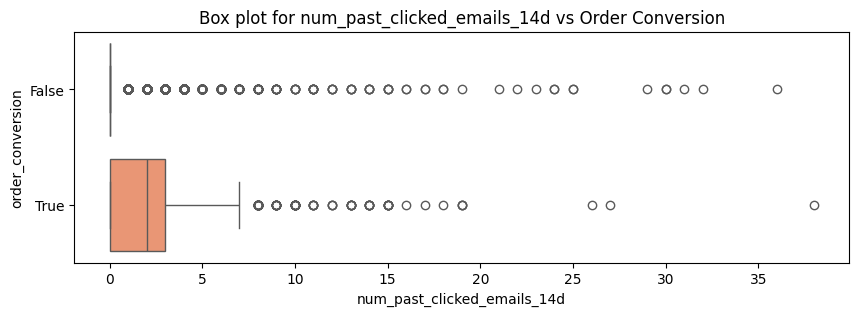

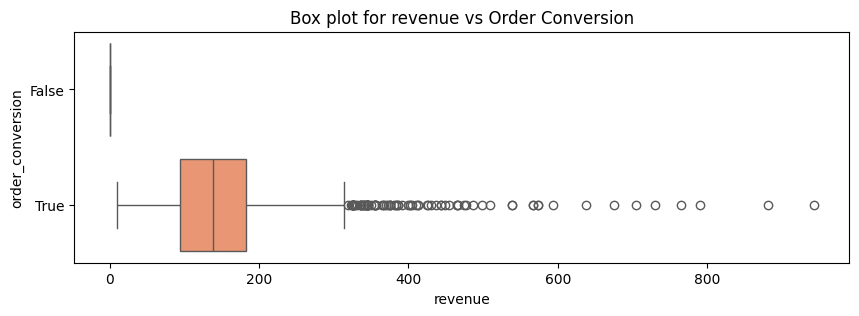

In [ ]:
# Boxplots for all numerical cols
numerical_cols = ['days_since_signup', 'loyalty_points', 'num_past_orders_14d', 'num_past_clicked_emails_14d','revenue']
target='order_conversion'
for col in numerical_cols:
    plt.figure(figsize=(10, 3))
    sns.boxplot(x=col, y=target, data=df, palette='Set2', orient='h')
    plt.title(f"Box plot for {col} vs Order Conversion")
    plt.xlabel(col)
    plt.ylabel(target)
    plt.show()

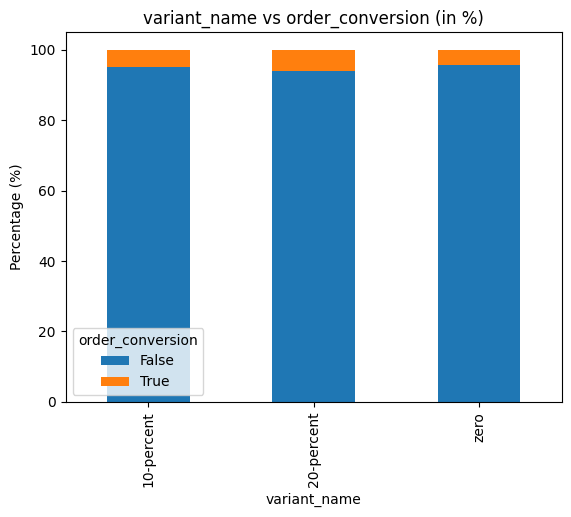

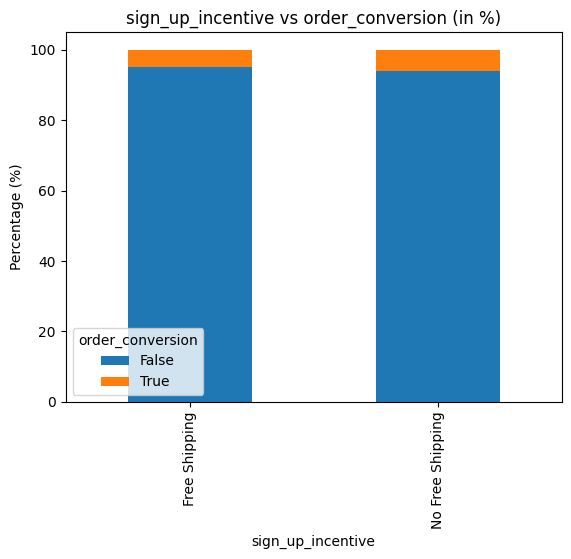

In [ ]:
categorical_cols = ['variant_name', 'sign_up_incentive']
for col in categorical_cols:
    # Create crosstab and normalize by row to get percentages
    crosstab = pd.crosstab(df[col], df[target], normalize='index') * 100  # Multiply by 100 for percentage

    # Plot stacked bar chart
    crosstab.plot(kind='bar', stacked=True)
    plt.title(f'{col} vs {target} (in %)')
    plt.xlabel(f'{col}')
    plt.ylabel('Percentage (%)')
    plt.show()

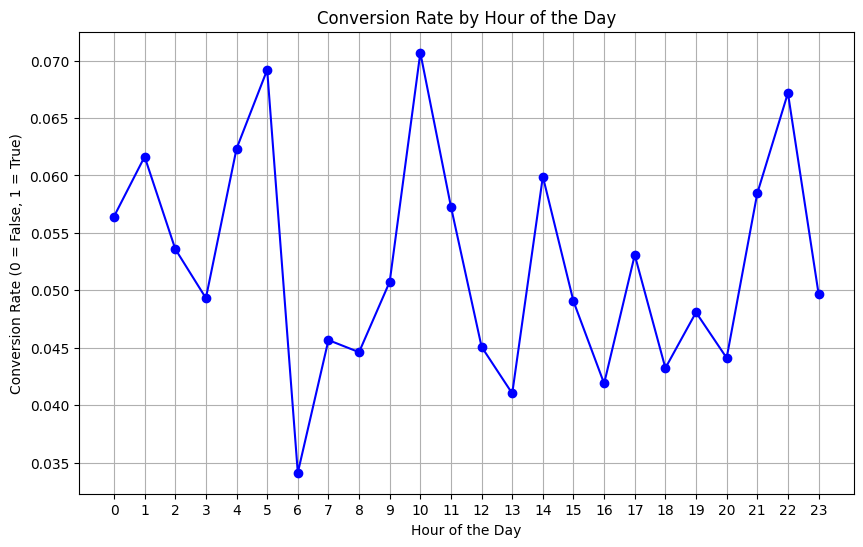

In [ ]:
df['exposed_at'] = pd.to_datetime(df['exposed_at'])

# Extract the hour of the day
df['hour'] = df['exposed_at'].dt.hour

# Convert the 'conversion' column to numeric (True = 1, False = 0)
df['conversion_numeric'] = df['order_conversion'].astype(int)

# Group by hour and calculate the mean conversion rate
hourly_conversion = df.groupby('hour')['conversion_numeric'].mean()

# Plot the conversion rate by hour
plt.figure(figsize=(10, 6))
plt.plot(hourly_conversion.index, hourly_conversion.values, marker='o', linestyle='-', color='blue')
plt.title('Conversion Rate by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Conversion Rate (0 = False, 1 = True)')
plt.xticks(range(24))  # Ensuring all 24 hours are shown
plt.grid(True)
plt.show()

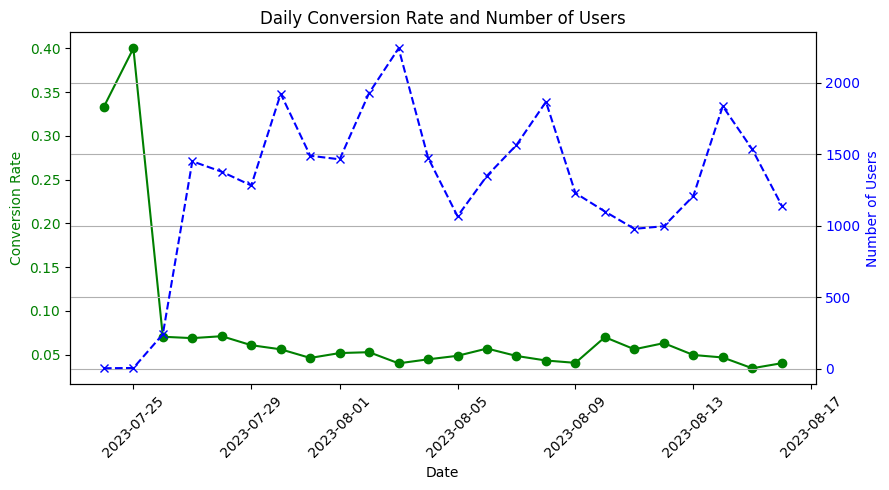

In [ ]:
# Daily Conversion Rate

# Convert 'exposed_at' to datetime (if not already done)
df['exposed_at'] = pd.to_datetime(df['exposed_at'])

# Extract the date (without time)
df['date'] = df['exposed_at'].dt.date

# Group by date and calculate the mean conversion rate
daily_conversion = df.groupby('date')['conversion_numeric'].mean()

# Count the number of users per day
daily_user_count = df.groupby('date')['conversion_numeric'].count()

# Plot both conversion rate and number of users
fig, ax1 = plt.subplots(figsize=(9, 5))

# Plot the conversion rate on the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Conversion Rate', color='green')
ax1.plot(daily_conversion.index, daily_conversion.values, marker='o', linestyle='-', color='green')
ax1.tick_params(axis='y', labelcolor='green')
plt.xticks(rotation=45)

# Create a secondary y-axis to plot the number of users
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Users', color='blue')
ax2.plot(daily_user_count.index, daily_user_count.values, marker='x', linestyle='--', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Daily Conversion Rate and Number of Users')
plt.grid(True)
plt.tight_layout()  # Adjust layout
plt.show()


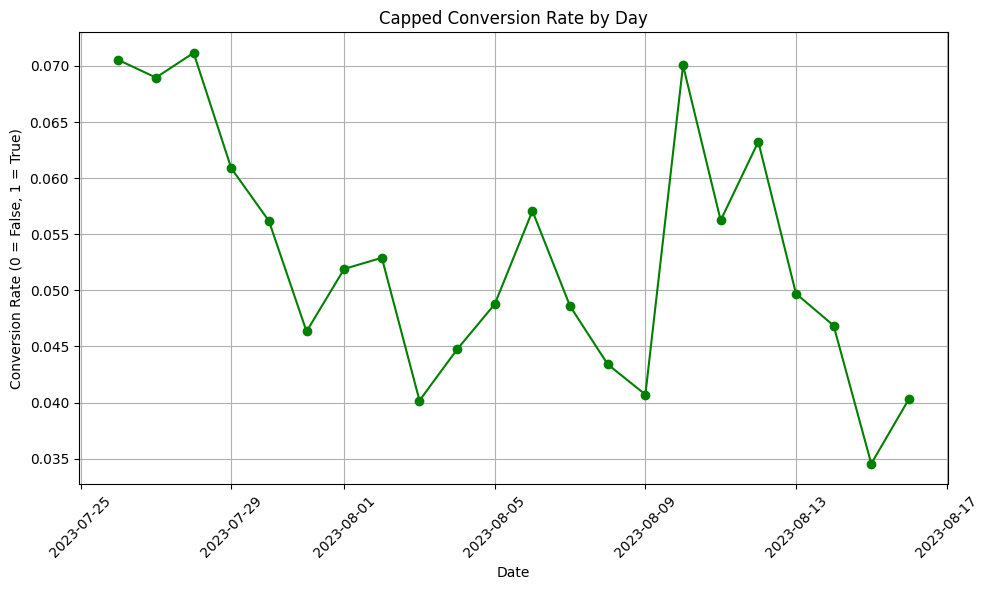

In [ ]:
#Remove the outliers by filtering the data before 2023-07-26 (There could be better methods, but for now let's do this.)
# Data Based Cleaning

cutoff_date = pd.to_datetime('2023-07-26')
df = df[df['exposed_at'] >= cutoff_date]

# Now, group by date and calculate the mean conversion rate after capping
daily_conversion_capped = df.groupby('date')['conversion_numeric'].mean()

# Plot the capped conversion rate by day
plt.figure(figsize=(10, 6))
plt.plot(daily_conversion_capped.index, daily_conversion_capped.values, marker='o', linestyle='-', color='green')
plt.title('Capped Conversion Rate by Day')
plt.xlabel('Date')
plt.ylabel('Conversion Rate (0 = False, 1 = True)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Correlation map
# corr = df.corr()
# sns.heatmap(corr, annot=True, cmap='coolwarm')
# plt.title('Correlation Heatmap')
# plt.show()

## Modeling and Evaluation (Logistic)

In [ ]:
# Let's only add numerical features for simplicity
features = ['days_since_signup', 'loyalty_points', 'num_past_orders_14d', 'num_past_clicked_emails_14d', 'variant_name']
target = 'order_conversion'

df.reset_index(drop=True, inplace=True)

# One-hot transformation
encoder = OneHotEncoder(drop='first')
encoded_coupons = encoder.fit_transform(df[['variant_name']]).toarray()

# Add all features
X = pd.concat([df[['days_since_signup', 'loyalty_points', 'num_past_orders_14d', 'num_past_clicked_emails_14d']], pd.DataFrame(encoded_coupons)], axis=1)
y = df[target]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Logistic regression model training
log_reg = LogisticRegression(penalty='l1', solver='liblinear',max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [ ]:
# Feature names
original_features = ['days_since_signup', 'loyalty_points', 'num_past_orders_14d', 'num_past_clicked_emails_14d']
encoded_coupon_features = encoder.get_feature_names_out(['variant_name'])

all_features = original_features + list(encoded_coupon_features)

# Coefficients from the logistic regression model
coefficients = log_reg.coef_[0]

coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
})

# Sorting the most impactful coefficients to least impactful for order conversion
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print(coef_df)


                       Feature  Coefficient
3  num_past_clicked_emails_14d     0.662027
4      variant_name_20-percent     0.197017
1               loyalty_points     0.000205
0            days_since_signup    -0.000309
5            variant_name_zero    -0.084533
2          num_past_orders_14d    -0.496507


In [ ]:
# Predict probabilities for the user being converted
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# This threshold was selected by manually tyring out by optimizing the F1-score. However, more robust method can be followed based on the
# selected model in future, and even MAB can be applied.
threshold = 0.1

# Predict class labels based on the custom threshold
y_pred = (y_pred_proba >= threshold).astype(int)


In [ ]:
# Model Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Confusion Matrix:
[[5631  230]
 [ 138  147]]
Precision: 0.3899
Recall: 0.5158
F1-Score: 0.4441


## Coupon Optimization

In [ ]:
# We'll check the conversion probability when different coupons are provided for the users

conversion_probs = simulate_coupon_impact(X_test, log_reg, encoder)

In [ ]:
'''
Coupon strategy to drive CVR from baseline 10% coupons to everyone.
'''
thresholds = (0.05,0.1) # Combination of lower and higher probability thresholds
X_test['segmented_coupon'] = customer_segmented_coupon(conversion_probs, coupon_percentage=0.5)

# Check the distribution of the newly assigned coupons
print(X_test['segmented_coupon'].value_counts())


segmented_coupon
zero          3073
20-percent    3067
10-percent       6
Name: count, dtype: int64


## Results (Business Impact)

In [ ]:
# Define the discount mapping for each coupon
discount_mapping = {'zero': 0.0, '10-percent': 0.10, '20-percent': 0.20}

#Assumption: Order value after coupon contact is same as revenue.
X_test['revenue'] = df.loc[X_test.index, 'revenue']

# Calculate KPIs based on the segmented coupon strategy
segmented_cvr, segmented_arpu = calculate_kpis(X_test, conversion_probs, discount_mapping)

# KPIs after Coupon Strategy
print(f"Segmented Conversion Rate (CVR): {segmented_cvr:.2f}%")
lift_in_cvr = ((segmented_cvr - baseline['conversion_rate'].values[0]*100) / (baseline['conversion_rate'].values[0]*100)) * 100

print(f"Lift in Conversion Rate from baseline is {lift_in_cvr:.2f}%")


Segmented Conversion Rate (CVR): 5.35%
Lift in Conversion Rate from baseline is 8.69%


## Functions

In [ ]:
def run_statistical_tests(df):
    '''
    Running statistical tests for CVR, ARPU, and AOV.
    '''
    print("Statistical Tests on KPIs from A/B Testing\n")
    # Create a contingency table for conversions and non-conversions across coupon variants
    contingency_table = pd.crosstab(df['variant_name'], df['order_conversion'])

    # Run the Chi-Square test
    chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)

    print(f"At 5% significane, Chi-Square Test p-value (Conversion Rate): {p_value_chi2}")

    # Get the ARPU values for each variant
    arpu_10 = df[df['variant_name'] == '10-percent']['revenue']
    arpu_20 = df[df['variant_name'] == '20-percent']['revenue']
    arpu_zero = df[df['variant_name'] == 'zero']['revenue']

    # Run ANOVA test for ARPU
    anova_arpu = f_oneway(arpu_10, arpu_20, arpu_zero)
    print(f"At 5% significance, ANOVA p-value (ARPU) is {anova_arpu.pvalue}")

    # Filter data for converted users only
    aov_10 = df[(df['variant_name'] == '10-percent') & (df['order_conversion'] == True)]['revenue']
    aov_20 = df[(df['variant_name'] == '20-percent') & (df['order_conversion'] == True)]['revenue']
    aov_zero = df[(df['variant_name'] == 'zero') & (df['order_conversion'] == True)]['revenue']

    # Run ANOVA test for AOV
    anova_aov = f_oneway(aov_10, aov_20, aov_zero)
    print(f"At 5% significance, ANOVA p-value (AOV): {anova_aov.pvalue}")


def simulate_coupon_impact(X_test, model, encoder):
    '''
    Predicting the probability of conversion given any user different types of coupons.
    '''
    coupon_options = ['zero', '10-percent', '20-percent']
    conversion_probs = {}

    for coupon in coupon_options:
        coupon_encoded = encoder.transform([[coupon]]).toarray()
        coupon_encoded_repeated = np.repeat(coupon_encoded, X_test.shape[0], axis=0)  # Repeat for all rows in X_test
        # Combineing features for encoding
        X_test_with_coupon = np.hstack([X_test[['days_since_signup', 'loyalty_points', 'num_past_orders_14d', 'num_past_clicked_emails_14d']].values, coupon_encoded_repeated])

        # Predict proabability for each coupon type
        conversion_probs[coupon] = model.predict_proba(X_test_with_coupon)[:, 1]

    return conversion_probs


def customer_segmented_coupon(conversion_probs, coupon_percentage=0.5):
    '''
    We'll create prob slabs for different coupons.
    Based on classification threshold from our best F1-score,

    We can segment users based on their probability of converting:
    if the probability without a coupon is above 0.1, no coupon is needed;
    if a 10% coupon increases their probability above 0.1, use that;
    otherwise, provide a 20% coupon.

    coupon_percentage is the amount of people who will recieve coupons. Most relatable for bulk coupon strategies (Note. Better optimization
    stragies can be explored).

    # After final constraint check, if more coupons are still available, users from Zero coupon will randomly be randomly selected
    and given 10% coupons.
    '''
    low_threshold, high_threshold = thresholds
    assigned_coupons = []

    # Coupon assignment
    for i in range(len(conversion_probs['zero'])):
        prob_20 = conversion_probs['20-percent'][i]
        prob_10 = conversion_probs['10-percent'][i]
        prob_0 = conversion_probs['zero'][i]

        if prob_0 > 0.1:
            assigned_coupons.append('zero')  # No coupon needed if prob_0 > 0.1
        elif prob_10 > 0.1:
            assigned_coupons.append('10-percent')  # Assign 10% coupon if prob_10 > 0.1
        else:
            assigned_coupons.append('20-percent')  # Assign 20% coupon otherwise

    # Calculate number of coupons to give
    num_users = len(assigned_coupons)
    num_coupons_to_give = int(coupon_percentage * num_users)

    # Identify users eligible for coupons (not 'zero')
    eligible_for_coupons = [i for i, coupon in enumerate(assigned_coupons) if coupon != 'zero']

    # Randomly select a subset of eligible users to receive coupons
    selected_users_for_coupons = np.random.choice(eligible_for_coupons, size=num_coupons_to_give, replace=False)

    # Set coupons for the selected users, and set the rest to 'zero' (no coupon)
    final_coupons = ['zero'] * num_users
    for i in selected_users_for_coupons:
        final_coupons[i] = assigned_coupons[i]

    # Final constraint check: assign remaining coupons if needed
    remaining_coupons_to_give = num_coupons_to_give - len(selected_users_for_coupons)

    if remaining_coupons_to_give > 0:
        users_with_zero_coupons = [i for i, coupon in enumerate(final_coupons) if coupon == 'zero']

        # Randomly select users who will receive the remaining coupons
        selected_for_remaining_coupons = np.random.choice(users_with_zero_coupons, size=remaining_coupons_to_give, replace=False)

        # Randomly assign either 10% or 20% coupon to the selected users
        for i in selected_for_remaining_coupons:
            final_coupons[i] = np.random.choice(['10-percent', '20-percent'])

    return final_coupons


def calculate_kpis(X_test, conversion_probs, discount_mapping):
    total_revenue = 0
    total_conversions = 0
    total_users = len(X_test)

    for i in range(total_users):
        # Get the coupon assigned
        assigned_coupon = X_test['segmented_coupon'].iloc[i]

        # Get the conversion probability and discount for the assigned coupon
        conversion_prob = conversion_probs[assigned_coupon][i]
        discount = discount_mapping[assigned_coupon]

        # Calculate expected revenue and total conversions
        expected_revenue = X_test.iloc[i]['revenue'] * (1 - discount)*1.1 * conversion_prob
        total_revenue += expected_revenue
        total_conversions += conversion_prob

    # Calculate Conversion Rate (CVR) and ARPU
    cvr = total_conversions / total_users * 100  # Conversion rate as a percentage
    arpu = total_revenue / total_users  # Average Revenue Per User

    return cvr, arpu